In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [2]:
import src
from src import *

In [3]:
data = datasets.data_original()
data.shape


(2139, 23)

In [4]:
data = features.engineer(data)

In [5]:
data.head()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,preanti,race,...,cd40,cd420,cd80,cd820,infected,time730,time_censored,trt0,trt1,trt2
0,48,89.8128,0,0,0,100,0,0,0,0,...,422,477,566,324,0,218,0,0,0,1
1,61,49.4424,0,0,0,90,0,1,895,0,...,162,218,392,564,1,272,0,0,0,0
2,45,88.4520,0,1,1,90,0,1,707,0,...,326,274,2063,1893,0,231,0,0,0,0
3,47,85.2768,0,1,0,100,0,1,1399,0,...,287,394,1590,966,0,436,0,0,0,0
4,43,66.6792,0,1,0,100,0,1,1352,0,...,504,353,870,782,0,360,0,1,0,0


In [6]:
# Carico il dataset
df=data
X=df.drop("infected",axis=1)
y=df["infected"]

## 059-Tune KNN Hyperparameters ##

In [7]:
# Suddivisione dei dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Creazione del modello KNN e definizione dei parametri
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10],'metric': ['euclidean', 'manhattan']}

In [9]:
# Grid Search con Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Miglior modello e valutazione
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7}
Best score: 0.8416057149676913
Test accuracy: 0.8411214953271028


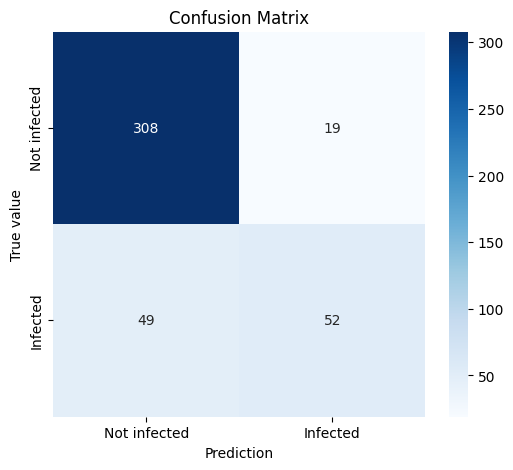

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

## 060-Cross Validation for KNN ##

In [11]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10],'metric': ['euclidean', 'manhattan']}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
best_knn = grid_search.best_estimator_
cv_scores = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy')


print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score(mean): {grid_search.best_score_}')

print(f'cv mean accuracy: {cv_scores.mean()}')
print(f"fold's accuracy: {cv_scores}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7}
Best score(mean): 0.838230208584123
cv mean accuracy: 0.838230208584123
fold's accuracy: [0.85747664 0.81074766 0.84813084 0.86214953 0.81264637]


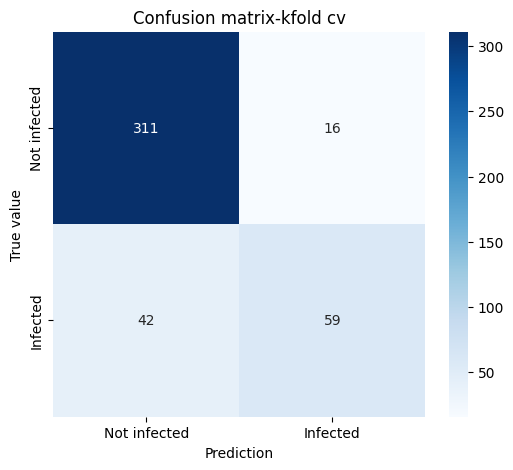

In [12]:
y_pred_cv = best_knn.predict(X_test)
cm_cv = confusion_matrix(y_test, y_pred_cv)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion matrix-kfold cv')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

## MinMaxScaler ##

In [38]:
# Carico il dataset
df = data
X = df.drop("infected", axis=1)
y = df["infected"]

# Suddivisione dei dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicazione di MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creazione del modello KNN e definizione dei parametri
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10], 'metric': ['euclidean', 'manhattan']}

# Grid Search con Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Miglior modello e valutazione
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best score: 0.8316658994424838
Test accuracy: 0.8434579439252337


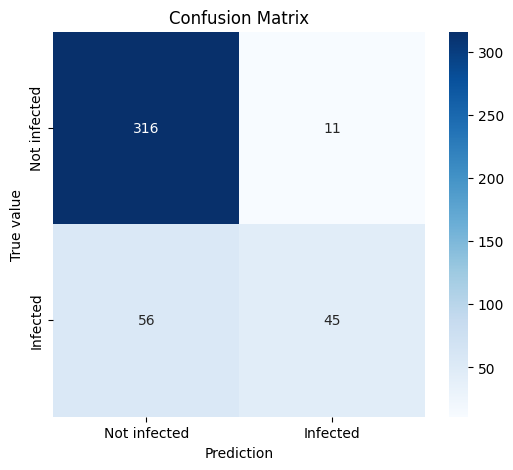

In [39]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

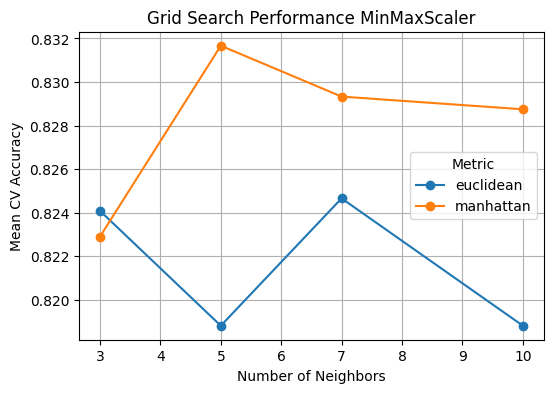

In [40]:
# Creazione del dataframe con i risultati della grid search
results = pd.DataFrame(grid_search.cv_results_)

# Line plot per visualizzare la variazione dell'accuratezza rispetto a 'n_neighbors' per ciascuna metrica
plt.figure(figsize=(6, 4))
for metric in results['param_metric'].unique():
    subset = results[results['param_metric'] == metric]
    plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], label=metric, marker='o')

# Configurazione del grafico
plt.title('Grid Search Performance MinMaxScaler')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Metric')
plt.grid()
plt.show()

## StandardScaler ##

In [41]:
# Carico il dataset
df = data
X = df.drop("infected", axis=1)
y = df["infected"]

# Suddivisione dei dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicazione di StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creazione del modello KNN e definizione dei parametri
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10], 'metric': ['euclidean', 'manhattan']}

# Grid Search con Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Miglior modello e valutazione
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7}
Best score: 0.84160741991032
Test accuracy: 0.8364485981308412


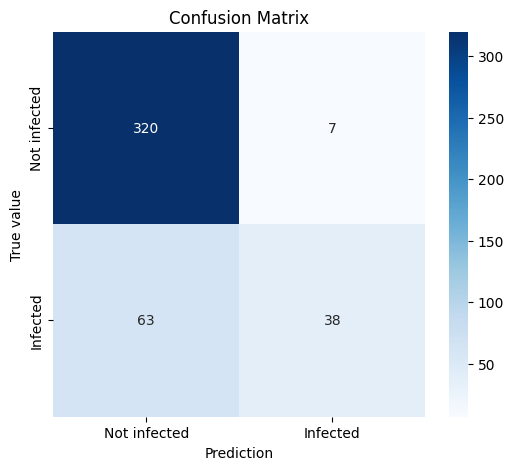

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

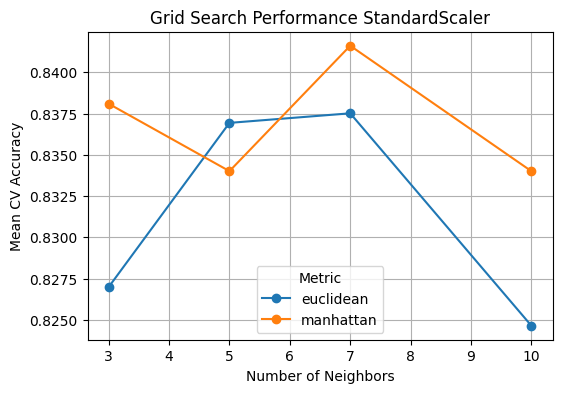

In [43]:
# Creazione del dataframe con i risultati della grid search
results = pd.DataFrame(grid_search.cv_results_)

# Line plot per visualizzare la variazione dell'accuratezza rispetto a 'n_neighbors' per ciascuna metrica
plt.figure(figsize=(6, 4))
for metric in results['param_metric'].unique():
    subset = results[results['param_metric'] == metric]
    plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], label=metric, marker='o')

# Configurazione del grafico
plt.title('Grid Search Performance StandardScaler')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Metric')
plt.grid()
plt.show()

## RobustScaler ##

In [7]:
# Carico il dataset
df = data
X = df.drop("infected", axis=1)
y = df["infected"]

# Suddivisione dei dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicazione di RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creazione del modello KNN e definizione dei parametri
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10], 'metric': ['euclidean', 'manhattan']}

# Grid Search con Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Miglior modello e valutazione
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best score: 0.8433703305883757
Test accuracy: 0.8387850467289719


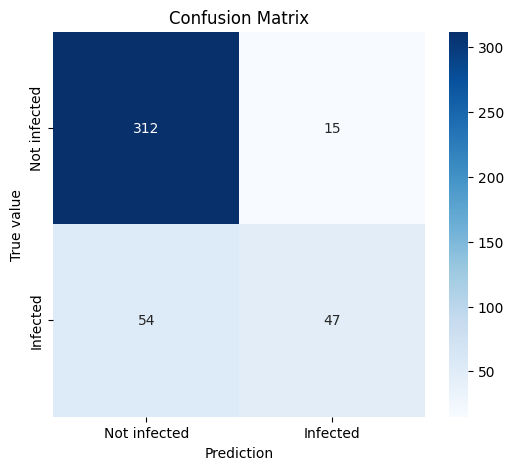

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

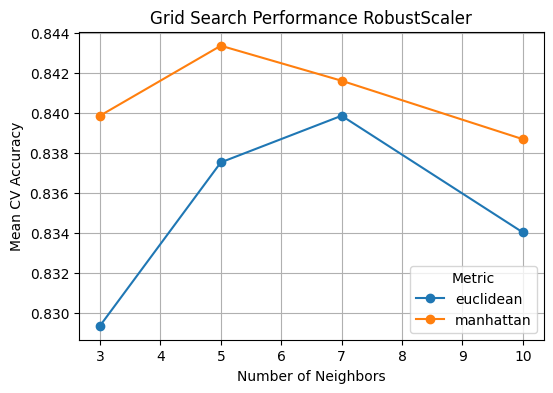

In [9]:
# Creazione del dataframe con i risultati della grid search
results = pd.DataFrame(grid_search.cv_results_)

# Line plot per visualizzare la variazione dell'accuratezza rispetto a 'n_neighbors' per ciascuna metrica
plt.figure(figsize=(6, 4))
for metric in results['param_metric'].unique():
    subset = results[results['param_metric'] == metric]
    plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], label=metric, marker='o')

# Configurazione del grafico
plt.title('Grid Search Performance RobustScaler')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Metric')
plt.grid()
plt.show()

In [11]:
model_knn = KNeighborsClassifier() 
X_knn_train = X_train_scaled
X_knn_test = X_test_scaled
model_knn.fit(X_knn_train,y_train)

KNeighborsClassifier()

In [13]:
import pickle

model = model_knn
filename = "models/knn.pkl"
file = open(filename, "wb")
pickle.dump(model, file)